In [35]:
from pathlib import Path

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from utils.data import get_hsm_dataset, get_solar_energy_dataset, get_fuel_prices_dataset, get_passengers_dataset, log_returns
from utils.visualization import visualization

In [22]:
hsm_dataset_dir = Path("data/huge_stock_market_dataset/")
se_dataset_dir = Path("data/solar_energy/")
fp_dataset_dir = Path("data/fuel_prices/")
ap_dataset_dir = Path("data/air_passengers/")
results_dir = Path("results")

In [3]:
hsm_info = pd.read_csv(hsm_dataset_dir / "selected100.csv")
hsm_info["ts_id"] = hsm_info.index

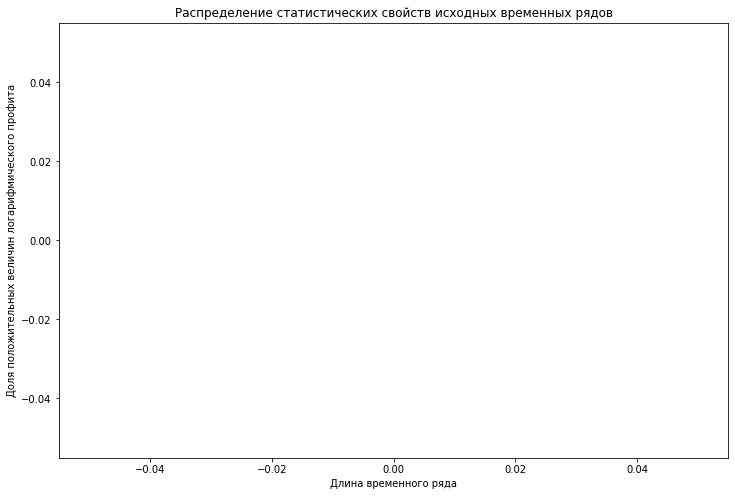

In [4]:
fig, ax = plt.subplots(figsize=(12, 8))
sns.scatterplot(hsm_info["length"], y=hsm_info["uptrending_rate"], ax=ax)
ax.set_xlabel("Длина временного ряда")
ax.set_ylabel("Доля положительных величин логарифмического профита")
ax.set_title("Распределение статистических свойств исходных временных рядов")
plt.show()

In [5]:
results = []
for results_type in ("real", "QuantGAN", "FourierFlow", "RealNVP", "TTS_GAN"):
    for model in ("LSTM", "TCN", "cbr"):
        for dataset_name in ("hsm", "se", "fp", "ap"):
            if results_type == "real":
                df = pd.read_csv(results_dir / f"{results_type}_{dataset_name}_{model}.csv")
            else:
                df = pd.read_csv(results_dir / f"synth_{results_type}_{dataset_name}_{model}.csv")
            df["model"] = model
            df["results_type"] = results_type
            df["dataset"] = dataset_name
            results.append(df)
results = pd.concat(results)
# results["model"].replace("cbr", "CatBoostRegressor", inplace=True)
# results["results_type"].replace(["pure", "QuantGAN_synth", "FourierFlow_synth", "RealNVP_synth", "TTS_GAN_synth"],
#                                 ["train set", "QuantGAN synthetic data", "FourierFlow synthetic data", "RealNVP synthetic data", "TTS GAN synthetic data"], 
#                                 inplace=True)
results

,test,model,results_type,dataset
0,0.415065,LSTM,real,hsm
1,0.567788,LSTM,real,hsm
2,0.680561,LSTM,real,hsm
3,0.825972,LSTM,real,hsm
4,0.410212,LSTM,real,hsm
...,...,...,...,...
45,0.838088,cbr,TTS_GAN,ap
46,0.778330,cbr,TTS_GAN,ap
47,0.848909,cbr,TTS_GAN,ap
48,0.790935,cbr,TTS_GAN,ap


In [6]:
results_agg = results.groupby(by=["model", "results_type", "dataset"], axis=0, as_index=False).agg(test=("test", "mean"))
results_agg

,model,results_type,dataset,test
0,LSTM,FourierFlow,ap,0.960249
1,LSTM,FourierFlow,fp,0.693573
2,LSTM,FourierFlow,hsm,0.606643
3,LSTM,FourierFlow,se,0.390937
4,LSTM,QuantGAN,ap,0.677491
5,LSTM,QuantGAN,fp,0.798805
6,LSTM,QuantGAN,hsm,0.712685
7,LSTM,QuantGAN,se,0.410153
8,LSTM,RealNVP,ap,6.713808
9,LSTM,RealNVP,fp,0.598064


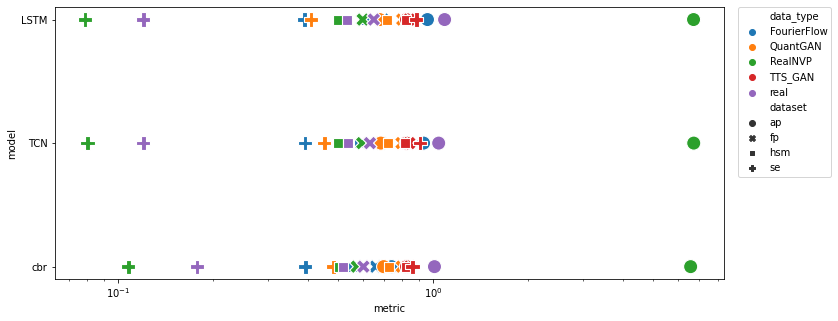

In [7]:
fig, ax = plt.subplots(figsize=(12, 5))
sns.scatterplot(x=results_agg["test"].rename("metric"), y=results_agg["model"], 
    hue=results_agg["results_type"].rename("data_type"), style=results_agg["dataset"], s=200, ax=ax)
ax.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0)
plt.xscale("log")
plt.show()

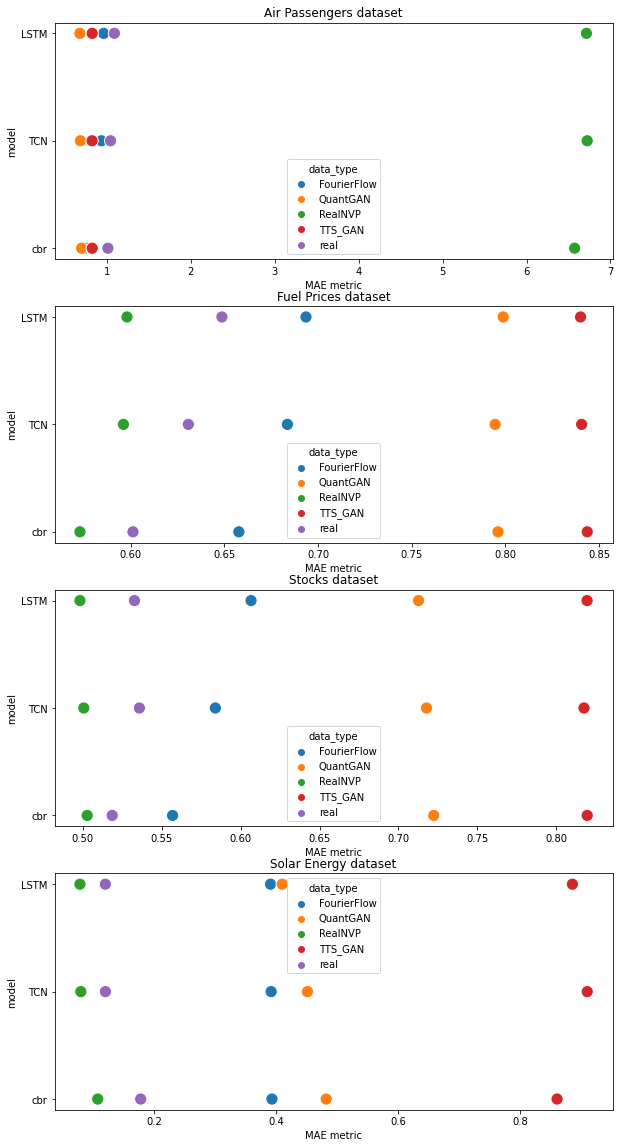

In [14]:
fig, axs = plt.subplots(4, figsize=(10, 20))
for i, dataset_name in enumerate(results_agg.dataset.unique()):
    loc_res = results_agg[results_agg.dataset == dataset_name]
    sns.scatterplot(x=loc_res["test"].rename("MAE metric"), y=loc_res["model"], hue=loc_res["results_type"].rename("data_type"),
     ax=axs[i], s=150)
    axs[i].set_title({"hsm": "Stocks", "se": "Solar Energy", "fp": "Fuel Prices", "ap": "Air Passengers"}[dataset_name] + " dataset")

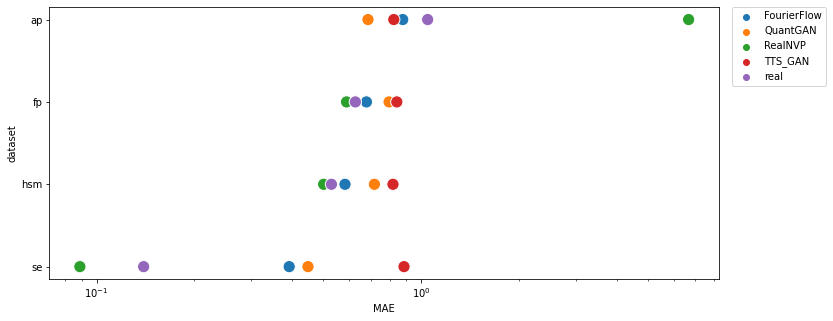

In [19]:
fig, ax = plt.subplots(figsize=(12, 5))
advanced_results_agg = results_agg.groupby(["dataset", "results_type"], as_index=False).agg(MAE=("test", "mean"))
sns.scatterplot(data=advanced_results_agg, x="MAE", y="dataset", hue="results_type", s=150, ax=ax)
ax.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0)
plt.xscale("log")
plt.show()

c:\Users\Владислав\AppData\Local\Programs\Python\Python38\lib\site-packages\pandas\core\internals\blocks.py:351: RuntimeWarning: divide by zero encountered in log
  result = func(self.values, **kwargs)


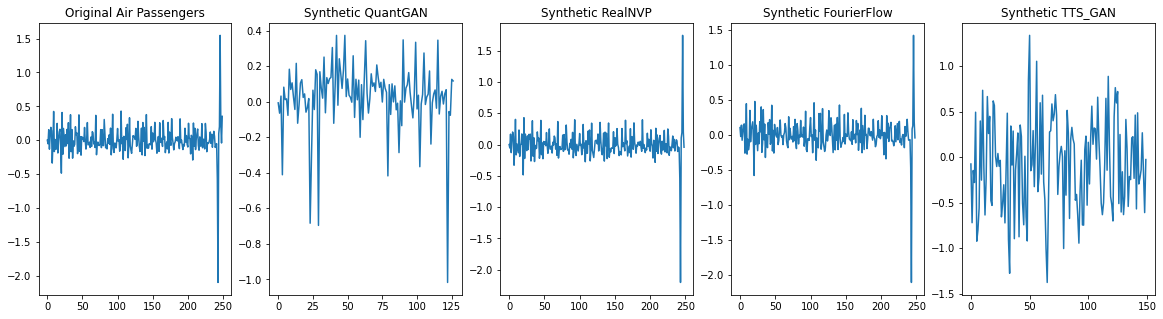

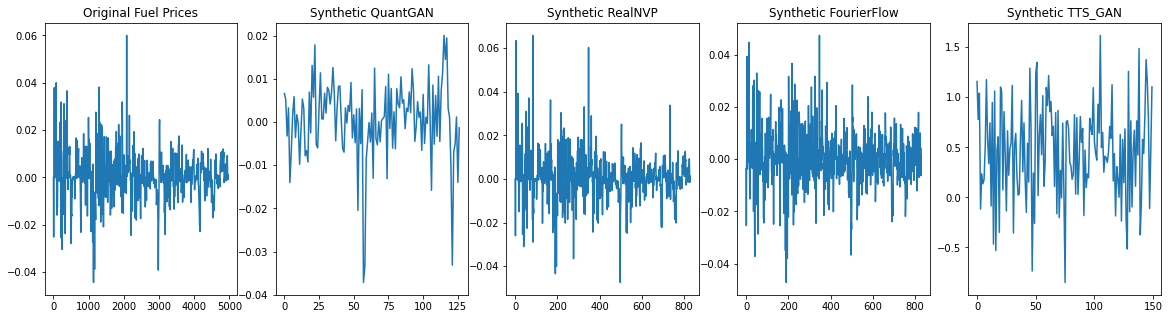

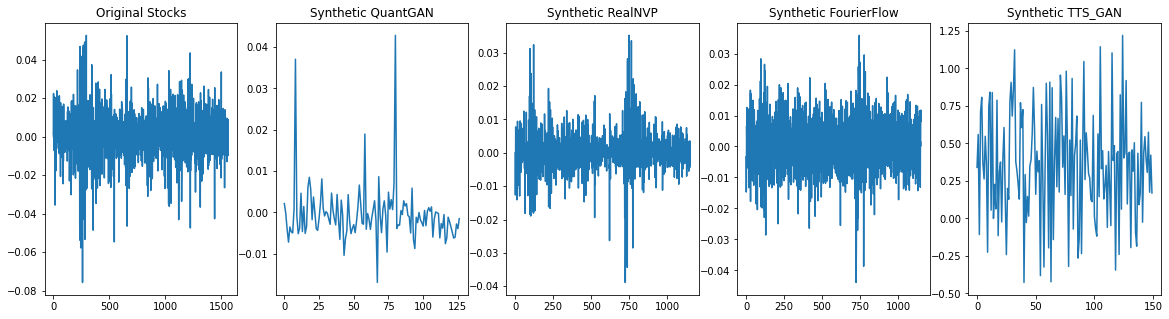

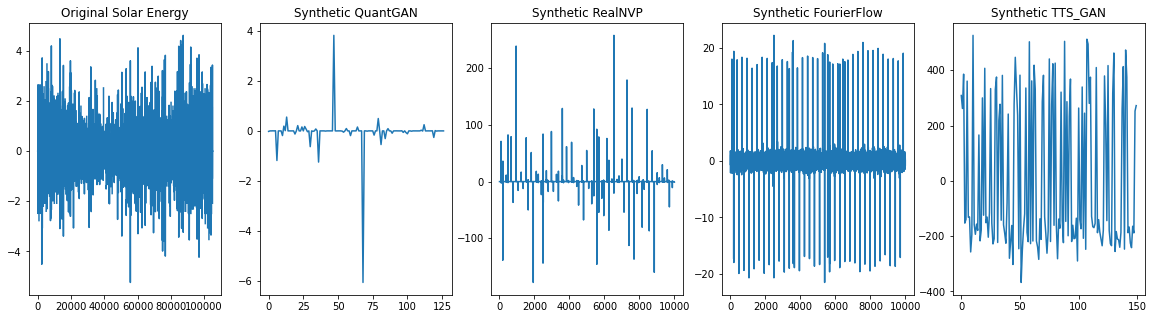

In [49]:
for dataset_name, dataset_dir, dataset_func in (
    ("Air Passengers", ap_dataset_dir, get_passengers_dataset),
    ("Fuel Prices", fp_dataset_dir, get_fuel_prices_dataset),
    ("Stocks", hsm_dataset_dir, get_hsm_dataset),
    ("Solar Energy", se_dataset_dir, get_solar_energy_dataset)
):
    time_series = next(dataset_func(dataset_dir))

    fig, axs = plt.subplots(1, 5, figsize=(20, 5))
    axs[0].plot(log_returns(time_series))
    axs[0].set_title(f"Original {dataset_name}")
    for i, model_name in zip(range(1, 5), ("QuantGAN", "RealNVP", "FourierFlow", "TTS_GAN")):
        synth_time_series = np.load(dataset_dir / f"synthetic/{model_name}/selected0.npy")
        axs[i].plot(synth_time_series[0].flatten())
        axs[i].set_title(f"Synthetic {model_name}")
plt.show()

# Synthetic similarity results

In [8]:
results = []
for model in ("QuantGAN", "RealNVP", "FourierFlow", "TTS_GAN"):
    for dataset_name in ("hsm", "se", "fp", "ap"):
        df = pd.read_csv(results_dir / f"synth_{dataset_name}_sim_{model}.csv").rename(columns={"sj_div": "js_div"})
        results.append({"model": model, "dataset": dataset_name,
        "kl_div": df["kl_div"].mean(), "js_div": df["js_div"].mean()})
synth_sim_results = pd.DataFrame(results)
synth_sim_results

,model,dataset,kl_div,js_div
0,QuantGAN,hsm,0.067871,0.018197
1,QuantGAN,se,0.093906,0.025480
2,QuantGAN,fp,0.098727,0.023304
3,QuantGAN,ap,0.088096,1.000000
4,RealNVP,hsm,0.007549,0.001956
5,RealNVP,se,0.020123,0.005023
6,RealNVP,fp,0.024043,0.005945
7,RealNVP,ap,0.100823,0.026480
8,FourierFlow,hsm,0.004134,0.001057
9,FourierFlow,se,0.000460,0.000114


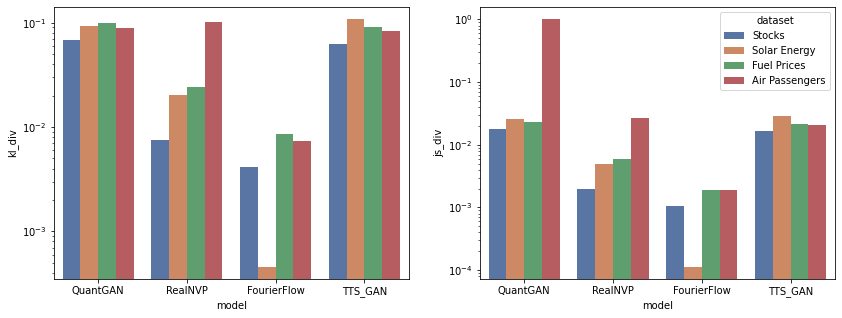

In [9]:
fig, axs = plt.subplots(1, 2, figsize=(14, 5))
for i, metric_name in enumerate(("kl_div", "js_div")):
    sns.barplot(x=synth_sim_results["model"], y=synth_sim_results[metric_name], 
        hue=synth_sim_results["dataset"].replace({"hsm": "Stocks", "se": "Solar Energy", "fp": "Fuel Prices", "ap": "Air Passengers"}),\
             ax=axs[i], palette="deep")
    axs[i].set_yscale("log")
axs[0].get_legend().remove()
plt.show()

In [10]:
dfs = {}
for res_type in ("real", "QuantGAN", "RealNVP", "FourierFlow", "TTS_GAN"):
    for model in ("cbr", "LSTM", "TCN"):
        for dataset_name in ("hsm", "se", "fp", "ap"):
            if res_type == "real":
                dfs[f"{res_type}_{model}_{dataset_name}"] = pd.read_csv(results_dir / f"{res_type}_{dataset_name}_{model}.csv")["test"]
            else:
                dfs[f"{res_type}_{model}_{dataset_name}"] = pd.read_csv(results_dir / f"synth_{res_type}_{dataset_name}_{model}.csv")["test"]
results = pd.DataFrame(dfs)
results

,real_cbr_hsm,real_cbr_se,real_cbr_fp,real_cbr_ap,real_LSTM_hsm,real_LSTM_se,real_LSTM_fp,real_LSTM_ap,real_TCN_hsm,real_TCN_se,...,TTS_GAN_cbr_fp,TTS_GAN_cbr_ap,TTS_GAN_LSTM_hsm,TTS_GAN_LSTM_se,TTS_GAN_LSTM_fp,TTS_GAN_LSTM_ap,TTS_GAN_TCN_hsm,TTS_GAN_TCN_se,TTS_GAN_TCN_fp,TTS_GAN_TCN_ap
0,0.401654,0.193247,0.443073,0.810873,0.415065,0.136675,0.459725,0.924060,0.403304,0.136627,...,0.856527,0.793796,0.781667,0.869790,0.858184,0.796087,0.783670,0.915316,0.856037,0.787671
1,0.536920,0.195709,0.423207,0.847820,0.567788,0.139915,0.440980,0.882098,0.569937,0.140487,...,0.878607,0.823583,0.797264,0.836445,0.871629,0.822556,0.798814,0.886362,0.866550,0.825550
2,0.651914,0.170422,0.586227,1.255740,0.680561,0.111841,0.631747,1.273527,0.694972,0.111904,...,0.841364,0.833850,0.865710,0.913982,0.844686,0.831953,0.864760,0.945612,0.849616,0.830759
3,0.774665,0.169113,0.376259,1.904409,0.825972,0.110642,0.382098,1.929218,0.802282,0.110606,...,0.816316,0.810690,0.712105,0.995523,0.805980,0.809388,0.716725,1.006423,0.811224,0.806813
4,0.423790,0.171898,0.718359,0.634024,0.410212,0.111111,0.786535,0.636217,0.404704,0.111037,...,0.858865,0.844162,0.869672,0.922551,0.858033,0.843782,0.864794,0.921938,0.851469,0.843180
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,0.634223,NaN,NaN,NaN,0.680089,NaN,NaN,NaN,0.648382,NaN,...,NaN,NaN,0.832135,NaN,NaN,NaN,0.825599,NaN,NaN,NaN
96,0.944157,NaN,NaN,NaN,1.059702,NaN,NaN,NaN,1.040683,NaN,...,NaN,NaN,0.825679,NaN,NaN,NaN,0.826824,NaN,NaN,NaN
97,0.440769,NaN,NaN,NaN,0.429882,NaN,NaN,NaN,0.435115,NaN,...,NaN,NaN,0.808820,NaN,NaN,NaN,0.809464,NaN,NaN,NaN
98,0.466428,NaN,NaN,NaN,0.449148,NaN,NaN,NaN,0.453674,NaN,...,NaN,NaN,0.794908,NaN,NaN,NaN,0.793913,NaN,NaN,NaN


In [11]:
corrs = []
ds_lens = {"hsm": 100, "se": 10, "fp": 8, "ap": 50}
for model in ("cbr", "LSTM", "TCN"):
    for res_type in ("QuantGAN", "RealNVP", "FourierFlow", "TTS_GAN"):
        for dataset_name in ("hsm", "se", "fp", "ap"):
            res = np.corrcoef([results[f"real_{model}_{dataset_name}"][:ds_lens[dataset_name]],
                results[f"{res_type}_{model}_{dataset_name}"][:ds_lens[dataset_name]]])[0][1]
            z = 0.5 * np.log((1 + res) / (1 - res))
            SE =  1 / (ds_lens[dataset_name] - 3) ** 0.5
            zl, zh = z - 1.96 * SE, z + 1.96 * SE
            lb, hb = ((np.e ** (2 * zl) - 1) / (np.e ** (2 * zl) + 1), (np.e ** (2 * zh) - 1) / (np.e ** (2 * zh) + 1))
            corrs.append({"model": model, "synth_model": res_type, "dataset": dataset_name, "correlation": res,\
                "low_bound": lb, "high_bound": hb})
corrs = pd.DataFrame(corrs)
corrs

,model,synth_model,dataset,correlation,low_bound,high_bound
0,cbr,QuantGAN,hsm,0.309590,0.120496,0.477005
1,cbr,QuantGAN,se,0.479963,-0.214491,0.852094
2,cbr,QuantGAN,fp,0.575258,-0.217654,0.910747
3,cbr,QuantGAN,ap,-0.125041,-0.389826,0.158840
4,cbr,RealNVP,hsm,0.983279,0.975205,0.988738
5,cbr,RealNVP,se,0.157367,-0.524208,0.716052
6,cbr,RealNVP,fp,0.945465,0.721451,0.990334
7,cbr,RealNVP,ap,0.860272,0.765139,0.918646
8,cbr,FourierFlow,hsm,0.925422,0.890951,0.949289
9,cbr,FourierFlow,se,-0.290193,-0.777725,0.415328


In [12]:
corrs_agg = corrs.groupby(["dataset", "synth_model"], as_index=False).mean()
corrs_agg

C:\Users\Владислав\AppData\Local\Temp/ipykernel_5684/2987291452.py:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  corrs_agg = corrs.groupby(["dataset", "synth_model"], as_index=False).mean()


,dataset,synth_model,correlation,low_bound,high_bound
0,ap,FourierFlow,0.613102,0.404942,0.761026
1,ap,QuantGAN,-0.142867,-0.405071,0.141049
2,ap,RealNVP,0.853374,0.754206,0.914488
3,ap,TTS_GAN,0.029494,-0.250899,0.305321
4,fp,FourierFlow,0.963611,0.812861,0.993559
5,fp,QuantGAN,0.566288,-0.230217,0.908444
6,fp,RealNVP,0.912710,0.587329,0.984269
7,fp,TTS_GAN,-0.126650,-0.763188,0.634627
8,hsm,FourierFlow,0.924234,0.889246,0.948470
9,hsm,QuantGAN,0.282526,0.091269,0.453691


<AxesSubplot:xlabel='synth_model', ylabel='correlation'>

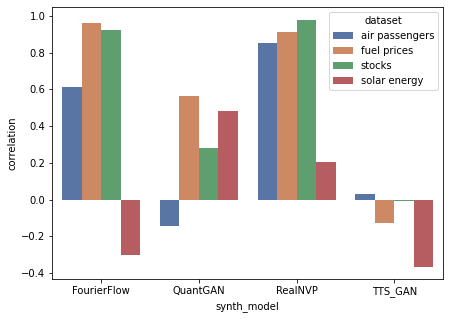

In [25]:
fig, ax = plt.subplots(figsize=(7, 5))
sns.barplot(x=corrs_agg["synth_model"], y=corrs_agg["correlation"],\
    hue=corrs_agg["dataset"].replace({"se": "solar energy", "hsm": "stocks", "fp": "fuel prices", "ap": "air passengers"}), \
        ax=ax, palette="deep")

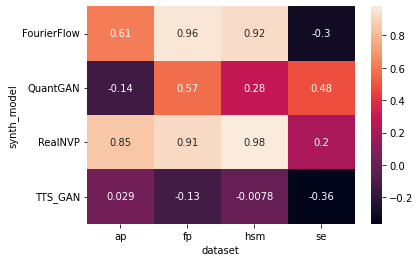

In [26]:
sns.heatmap(
    corrs_agg.pivot_table(index="synth_model", columns="dataset", values="correlation", aggfunc=np.mean),
    annot=True
)
plt.show()

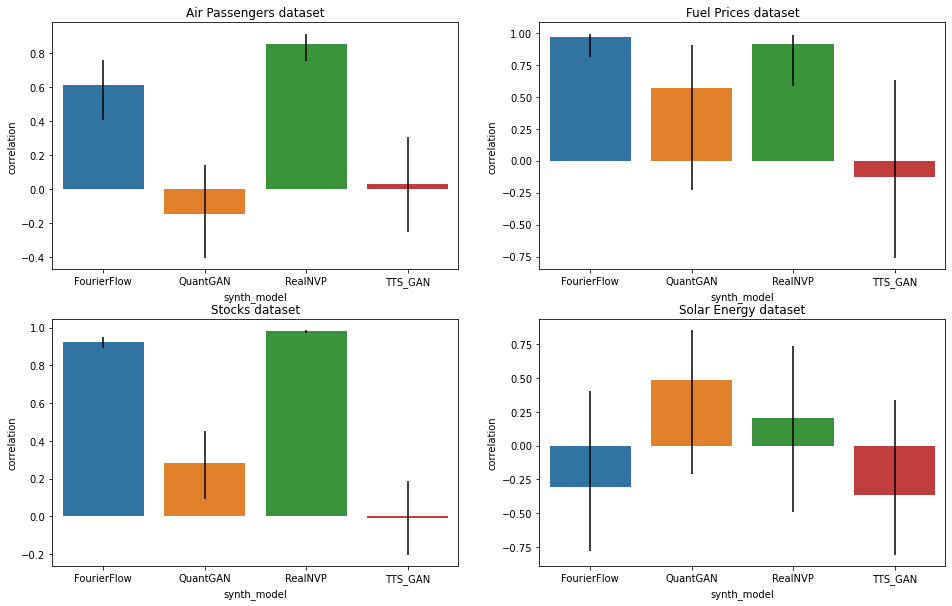

In [49]:
fig, axs = plt.subplots(2, 2, figsize=(16, 10))
for i, dsname in enumerate(corrs_agg.dataset.unique()):
    loc_data = corrs_agg[corrs_agg.dataset == dsname]
    sns.barplot(data=loc_data, x="synth_model", y="correlation",\
        yerr=(loc_data["correlation"] - loc_data["low_bound"], loc_data["high_bound"] - loc_data["correlation"]), ax=axs[i // 2][i % 2])
    axs[i // 2][i % 2].set_title({"se": "Solar Energy", "hsm": "Stocks", "fp": "Fuel Prices", "ap": "Air Passengers"}[dsname] + " dataset")